# 1. Introduction

In this section, we will perform exploratory data analysis (EDA) by data visualization. In particular, we would like to explore the distributions of various features and how they are related to price, the target variable. 

In [2]:
#import packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
% matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
sns.set_context('notebook')
pd.set_option('display.max_columns', 1000)

In [5]:
#import cleaned data from the data wrangling procedure
df = pd.read_csv('./data/df_cleaned.csv', encoding='utf-8')

# 2. Exploratory Data Analysis

## 2.1 Price

###  2.1.1 What is the distribution of nightly price?

In [5]:
df.price.describe()

count    20769.000000
mean       143.288074
std        234.157135
min          0.000000
25%         64.000000
50%        101.000000
75%        160.000000
max      13422.000000
Name: price, dtype: float64

The statistical summary reveals a few interesting facts:  
1. There are 4 listings with price of \$0.  
2. The median price is \$101, and the average price is $143.  
3. The distribution is highly right-skewed, with the maximum price of \$13,422.
    
Becase of the extreme values, it may be more appropriate to apply log transformation to the price and evaluate its distribution.

First, the url's of those listings with price = 0 were visited and the prices were confirmed erroneous. To prevent issues with log transformation, those listings are deleted.

In [7]:
drop_index = df[df.price==0].index
for idx in drop_index:
    df.drop(idx,axis=0,inplace=True)

Statistics after removing those values:

In [11]:
df.price.describe()

count    20765.000000
mean       143.315675
std        234.171241
min         13.000000
25%         64.000000
50%        101.000000
75%        160.000000
max      13422.000000
Name: price, dtype: float64

In [12]:
df['log_price'] = np.log(df.price)

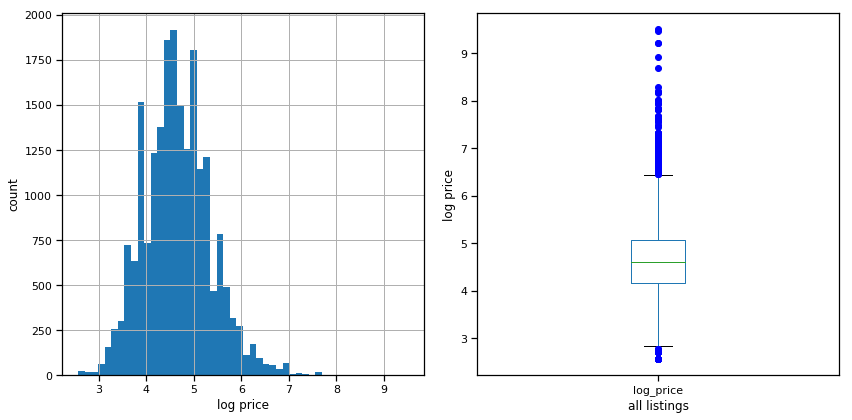

In [16]:
plt.subplot(1,2,1)
df.log_price.hist(bins=50)
plt.xlabel('log price')
plt.ylabel('count')
plt.subplot(1,2,2)
df.log_price.plot.box(sym='b')
plt.ylabel('log price')
plt.xlabel('all listings')
plt.tight_layout()

The histogram (left) shows that the log price is slightly right skewed. The boxplot (right) shows that most of the outliers are above 1.5x of the inter-quartile range (IQR). 

## 2.2 Geographical Information

### 2.2.1.a Where are the properties located? 

In [46]:
df.city_fsa.value_counts()

Downtown Toronto    7938
West Toronto        3361
North York          2749
Central Toronto     1426
Scarborough         1359
Etobicoke           1083
East Toronto        1069
York                 707
East York            671
Other                403
Not assigned           2
Queen's Park           1
Name: city_fsa, dtype: int64

In [18]:
city_order = ['Downtown Toronto','Central Toronto','East Toronto','West Toronto','York','North York','East York',
              'Scarborough','Etobicoke',"Queen's Park", 'Other','Not assigned']

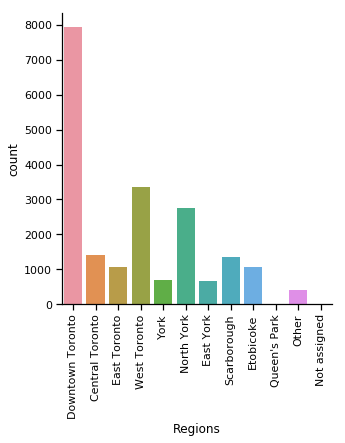

In [19]:
g = sns.catplot(data=df,x='city_fsa',kind='count',order=city_order)
g.set(xlabel='Regions')
plt.xticks(rotation=90);

Overall, the Toronto area (Downtown, Central, East and West) has the most combined listing. Among them, the Downtown are has the most listing.  
The York region (York, North York and East York) has the 2nd most combined listing.
There are 2 listings with FSA that are not assigned, and 403 listings with unknown FSA.

### 2.2.1.b Is the price affected by the listing's location?

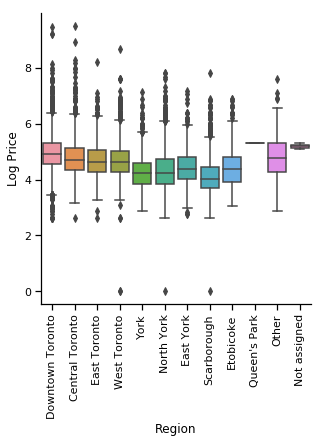

In [80]:
g=sns.catplot(data=df, x='city_fsa',y='log_price', kind='box',order=city_order)
g.set(ylabel='Log Price',xlabel='Region')
plt.xticks(rotation=90);

For most regions, the prices are right skewed, with more outliers on the high end than on the low end.  

The median price is highest in Downtown Toronto, and lowest in Scarborough.  

The listings with highest prices (>\$10,000) are in Downtown Toronto and Central Toronto. 

## 2.3 Property Information

### 2.3.1.a What are the property types?

In [20]:
# Create a function for count and percentage for categorical variables

def count_pct(variable, data=df):
    idx = data[variable].value_counts().index
    count_pct_dict = {'count': data[variable].value_counts(dropna=False).values,
                      'pct':data[variable].value_counts(dropna=False).values/data.shape[0]*100}
    return pd.DataFrame(count_pct_dict,index=idx)

In [21]:
property_type_counts = count_pct(variable = 'property_type')
property_type_counts

,count,pct
Apartment,6159,29.660486
Condominium,5508,26.525403
House,5499,26.482061
Townhouse,967,4.656875
Guest suite,796,3.833373
Bungalow,679,3.269925
Loft,443,2.133398
Serviced apartment,217,1.045028
Guesthouse,109,0.524922
Bed and breakfast,103,0.496027


In [155]:
len(df.property_type.unique()), (property_type_counts['count'] <= 10).sum()

(30, 16)

Overall, there are 30 different property types.  
The most common ones are: Apartment (29.7%), Condominum (26.5%), and House (26.5%).  
There are 16 property types that have count of 10 or fewer.

### 2.3.1.b Does property type affect nightly price?

In [26]:
# create and index so for ordering the boxplots according to counts
idx = df.property_type.value_counts().index

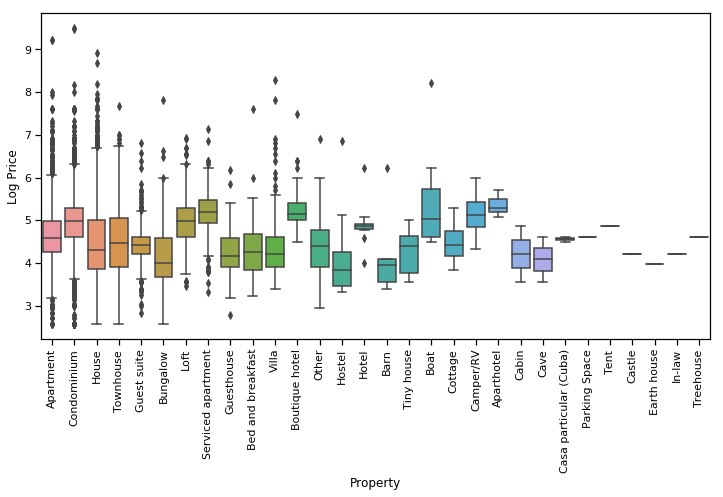

In [27]:
# create and index so for ordering the boxplots according to counts
idx = df.property_type.value_counts().index
g = sns.boxplot(data=df, x='property_type', y='log_price',order=idx)
g.set(ylabel ='Log Price', xlabel='Property')
plt.xticks(rotation=90);

With this level of granularity, it is hard to draw any conclusions because many categories have small numbers of listings.  
For simplicity, the categories with high number of counts are evaluated.

In [35]:
# Set threshold to be 3% of total number of listing; only property type higher than threshold will be considered
threshold = 3
top_property_type = property_type_counts[property_type_counts.pct > threshold].index
df_top_property_type = df.loc[df.property_type.apply(lambda x: x in top_property_type),['property_type','log_price','room_type']]

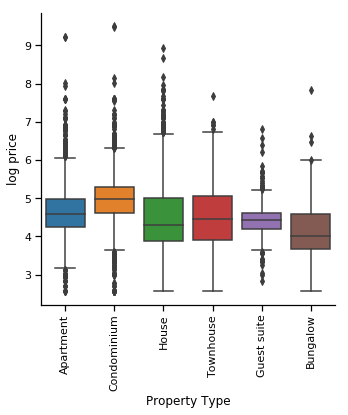

In [36]:
g = sns.catplot(data=df_top_property_type, x='property_type',y='log_price',kind='box',order =top_property_type)
g.set(xlabel = 'Property Type', ylabel='log price')
plt.xticks(rotation = 90);

Condominium has the highest median price, while bungalow has the lowest median price.  
Note that the word "bungalow" originates from the Hindi word "bangala". According to [wikipedia](https://en.wikipedia.org/wiki/Bungalow), "Canada uses the definition of bungalow to mean a single-family dwelling that is one storey high." So in reality they should belong to the "house" category.

## 2.3.2.a What are the available room types?

In [37]:
room_type_counts = count_pct('room_type')
room_type_counts

,count,pct
Entire home/apt,13361,64.343848
Private room,7036,33.883939
Shared room,368,1.772213


There are three room types. About two thirds (64%) are entire home or apartment, while one third (34%) are private room. Shared room consists of less than 2%. 

### 2.3.2.b What is the distribution of room type among the top property types?

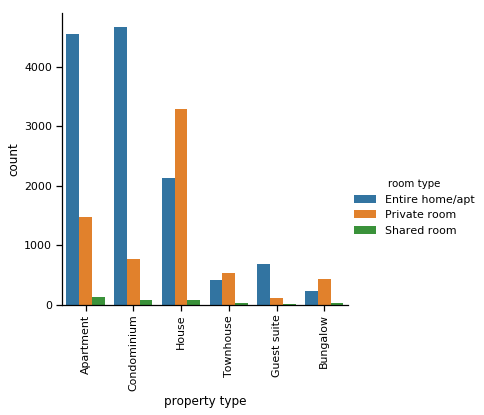

In [38]:
g = sns.catplot(data=df_top_property_type, x='property_type',hue='room_type',kind='count',order=top_property_type)
g._legend.set_title('room type')
g.set(xlabel='property type')
plt.xticks(rotation=90);

For apartment and condominium, the majority room type is the entire unit, where private room is the most common for house and bungalow.

### 2.3.2.c. How does room type affect price?

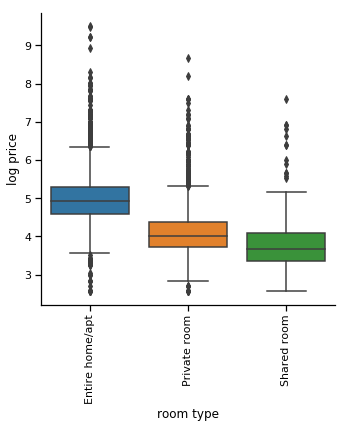

In [156]:
g = sns.catplot(data=df, x='room_type', y='log_price',kind='box')
g.set(xlabel='room type',ylabel='log price')
plt.xticks(rotation=90);

As expected, the price is the highest for renting the entire unit, followed by private room. The price for shared room is generally the lowest. 

### 2.3.3.a What is the distribution of number of accommodates?

The number of accommodates refers to the maximum number of guests the unit can host.

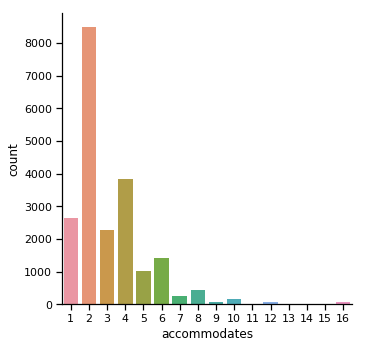

In [167]:
sns.catplot(data=df,x='accommodates',kind='count');

The most common number of accommodates is 2, and the maximum value is 16.

### 2.3.3.b. Is price related to the number of accommodates?

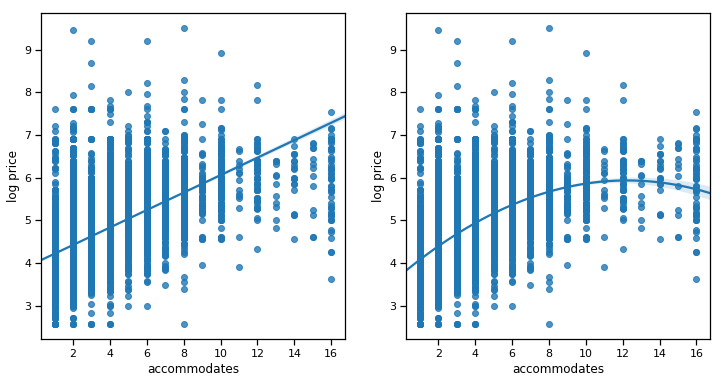

In [154]:
plt.subplot(1,2,1)
g = sns.regplot(data=df, x='accommodates',y='log_price', order=1);
g.set(ylabel='log price')
plt.subplot(1,2,2)
g = sns.regplot(data=df, x='accommodates',y='log_price', order=2);
g.set(ylabel='log price');

There seems to be an increase in log price with accommodates; however, the left graph shows the increase is not linear.

Fitting a 2nd order regression line to the data, as shown in the rigth graph, log price increases with accommodates up until around value of 10, where afterwards the log price tapers.

### 2.3.4.a What are the most 20 common amenities? 

In [129]:
amenities_col_list = df.columns[list(map(lambda x: True if "amenities_" in x else False, df.columns))]

In [130]:
df.loc[:,x].sum().sort_values(ascending=False)[:20]

amenities_wifi                         20380
amenities_heating                      20105
amenities_essentials                   19750
amenities_smoke detector               19533
amenities_kitchen                      19139
amenities_air conditioning             17742
amenities_hangers                      17602
amenities_washer                       16808
amenities_carbon monoxide detector     16668
amenities_shampoo                      16613
amenities_dryer                        16553
amenities_laptop friendly workspace    15619
amenities_hair dryer                   15316
amenities_tv                           14670
amenities_iron                         14651
amenities_hot water                    12262
amenities_fire extinguisher            10746
amenities_refrigerator                  9433
amenities_dishes and silverware         8701
amenities_elevator                      8675
dtype: int64

The most common amenities are the ones that one would expect in a typical living place. It is also possible that some amenities are so trivial (e.g. hot water) the hosts have neglected to include them.   

### 2.3.4.b What are the least common 20 amenities?

In [131]:
df.loc[:,x].sum().sort_values()[:20]

amenities_tennis court           1
amenities_brick oven             1
amenities_pool toys              1
amenities_hammock                1
amenities_washer / dryer         2
amenities_heat lamps             2
amenities_mobile hoist           2
amenities_ground floor access    2
amenities_private gym            2
amenities_alfresco bathtub       2
amenities_pool cover             2
amenities_private pool           3
amenities_ceiling hoist          3
amenities_touchless faucets      3
amenities_standing valet         3
amenities_fax machine            4
amenities_outdoor kitchen        4
amenities_air purifier           4
amenities_mountain view          5
amenities_private hot tub        5
dtype: int64

Some items do seem unique to listings (e.g. tennis court, mountain view), but there are also washer / dryer that in reality is a washer.  

Features can be further combined to reduce dimensionality.

### What amenities lead to the largest change in median price?

In [149]:
df_amenities = pd.DataFrame(columns = ['with_amenities_count','with_amenities_price',
                                       'without_amenities_count','without_amenities_price'])
for item in amenities_col_list:
    df_amenities.loc[item]=[df.loc[df[item]==1,'price'].count(), df.loc[df[item]==1,'price'].median(),
                            df.loc[df[item]==0,'price'].count(), df.loc[df[item]==0,'price'].median()]
df_amenities['difference'] = df_amenities.with_amenities_price - df_amenities.without_amenities_price

In [152]:
df_amenities.sort_values(by='difference', ascending=False)[:10]

,with_amenities_count,with_amenities_price,without_amenities_count,without_amenities_price,difference
amenities_private gym,2.0,2047.5,20763.0,101.0,1946.5
amenities_private pool,3.0,796.0,20762.0,101.0,695.0
amenities_outdoor kitchen,4.0,747.5,20761.0,101.0,646.5
amenities_pool toys,1.0,403.0,20764.0,101.0,302.0
amenities_private hot tub,5.0,403.0,20760.0,101.0,302.0
amenities_tennis court,1.0,403.0,20764.0,101.0,302.0
amenities_double oven,8.0,367.0,20757.0,101.0,266.0
amenities_projector and screen,5.0,334.0,20760.0,101.0,233.0
amenities_alfresco bathtub,2.0,326.5,20763.0,101.0,225.5
amenities_heated towel rack,7.0,321.0,20758.0,101.0,220.0


Having a private gym leads to the highest increase in median price. However, with only 2 listings with private gym, the results can be biased.

## 2.4 Host Information

### 2.4.1.a. What fraction of listings are provided by superhosts? 

Superhost is a status granted by Airbnb to hosts for their proven track records of providing extraordinary services to customers.

In [42]:
superhost_count_pct = count_pct('host_is_superhost')
superhost_count_pct

,count,pct
f,15344,73.893571
t,5421,26.106429


About 26% of listings are provided by superhost. It is important to note that a host can provide multiple listings.

### 2.4.1.b. Are the prices different between the superhost and non-superhost?

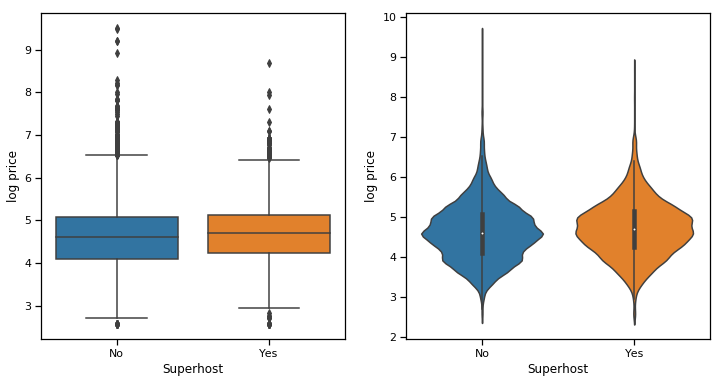

In [41]:
plt.subplot(1,2,1)
sns.boxplot(data=df, x='host_is_superhost', y='log_price')
plt.xticks([0,1],['No','Yes'])
plt.xlabel('Superhost')
plt.ylabel('log price')

plt.subplot(1,2,2)
sns.violinplot(data=df, x='host_is_superhost', y='log_price')
plt.xticks([0,1],['No','Yes'])
plt.xlabel('Superhost')
plt.ylabel('log price');

The median price for listings offered by superhost is slightly higher. Yet, the listings with the highest prices are owned by non-superhosts.

### 2.4.2.a. What is distribution of the the response time?

In [277]:
df_host_response_time = count_pct('host_response_time')
df_host_response_time

,count,pct
within an hour,16336,78.655689
within a few hours,2435,11.724204
within a day,1639,7.891569
a few days or more,359,1.728538


In [ ]:
Close to 80% of listings are posted by hosts that reply within an hour of inquiry.

### 2.4.2.b. Is host response time related to price?

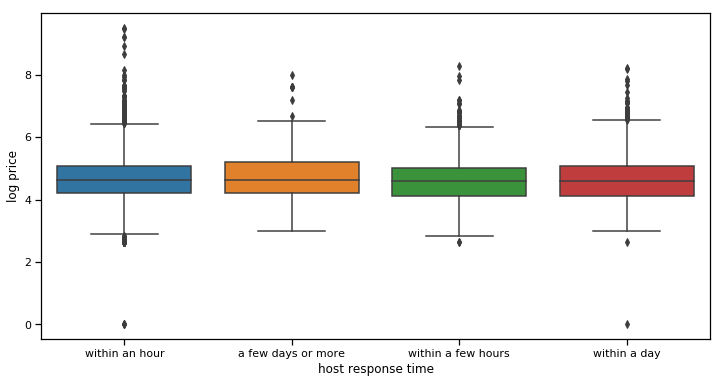

In [302]:
g = sns.boxplot(data=df, x='host_response_time',y='log_price')
plt.xlabel('host response time')
plt.ylabel('log price');

The host response time does not seem to relate to the price.

## 2.5 Booking Policy 

### 2.5.1.a. What is the distribution of cleaning fee?

Cleaning fee is a fixed charged for every booking regardless of the duration of stay.

In [301]:
df.cleaning_fee.describe()

count    20769.000000
mean        50.455294
std         50.654672
min          0.000000
25%         14.000000
50%         40.000000
75%         75.000000
max        962.000000
Name: cleaning_fee, dtype: float64

The cleaning fee is right skewed and shows considerable variation. The minimum and maximum values are 0 (free of charge) and 962, respectively.  

Note that missing cleaning fees are imputed with 0.

Due to the extreme values, applying log transformation would be appropriate.

In [51]:
df['log_cleaning_fee'] = np.log(df.cleaning_fee+1)

''

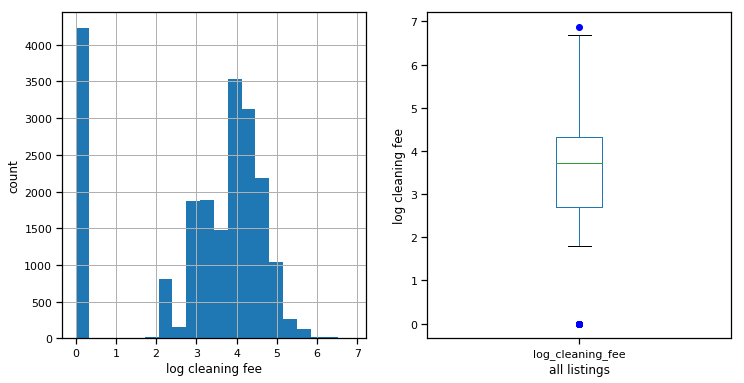

In [52]:
plt.subplot(1,2,1)
df.log_cleaning_fee.hist(bins=20)
plt.xlabel('log cleaning fee')
plt.ylabel('count')
plt.subplot(1,2,2)
df.log_cleaning_fee.plot.box(sym='b')
plt.xlabel('all listings')
plt.ylabel('log cleaning fee')
;

In [58]:
print(f'Number of listings with 0 cleaning fee: {(df.cleaning_fee == 0).sum()}')
print(f'Number of listings without cleaning fee: {(df.cleaning_fee_NA == True).sum()}')

Number of listings with 0 cleaning fee: 4232
Number of listings without cleaning fee: 3384


Since cleaning fee is fixed, the longer the stay, the lower the cleaning fee per day. Cleaning fee is part of the pricing strategy for the host. Priced correctly, the listing can appear more attractive to customers.

It would be interesting to see the ratio between cleaning fee and nightly rate.

In [53]:
df['ratio_cleaning_fee_price'] = np.divide(df.cleaning_fee,df.price)

In [54]:
df.ratio_cleaning_fee_price.describe()

count    20765.000000
mean         0.431313
std          0.485422
min          0.000000
25%          0.166667
50%          0.375940
75%          0.591716
max         20.000000
Name: ratio_cleaning_fee_price, dtype: float64

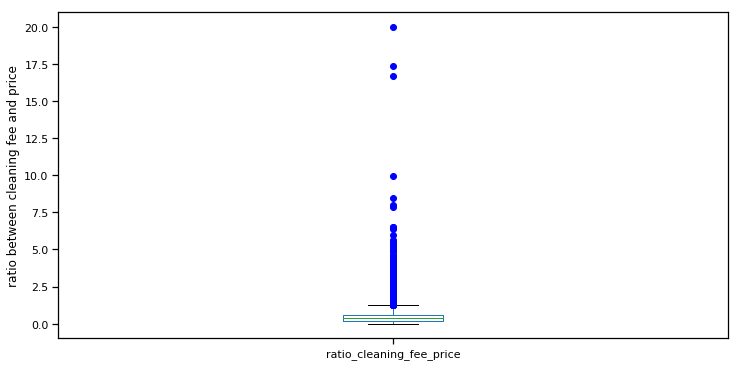

In [338]:
df.ratio_cleaning_fee_price.plot.box(sym='b')
plt.ylabel('ratio between cleaning fee and price');

The cleaning fees of 75% of listings are below 60% of nightly rate. However, there are considerable amount of outliers on the right side of the distribution, with the maximum value of 20, i.e. the cleaning fee is 20 times the nightly price. It represents a pricing strategy of making the cleaning fee a higher proportion of revenue.

### 2.5.1.b What is the relationship between cleaning fee and price?

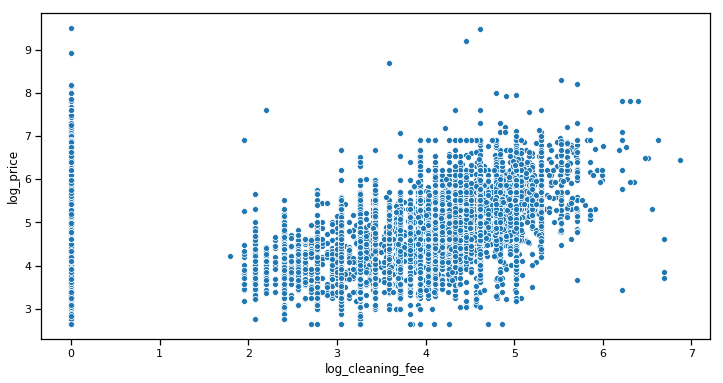

In [348]:
sns.scatterplot(x='log_cleaning_fee',y='log_price',data=df)

There are two distinct clusters in the scatter plot. On the left, the cleaning fee is 0, where on the right, cleaning fee is positively correlated with price. 

### 2.5.2 is the number of guests included related to price? 

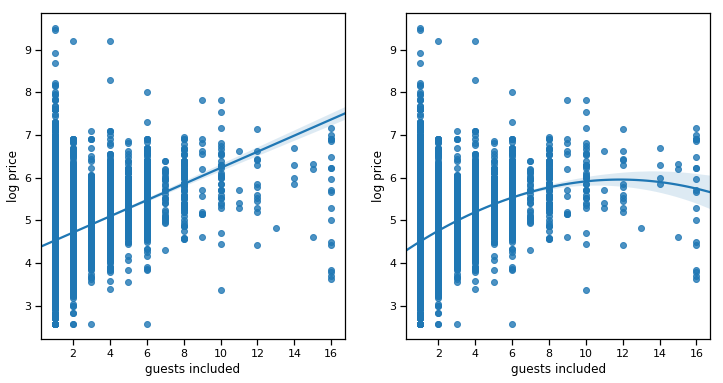

In [167]:
plt.subplot(1,2,1)
sns.regplot(data=df, x='guests_included',y='log_price',order=1)
plt.xlabel('guests included')
plt.ylabel('log price')
plt.subplot(1,2,2)
sns.regplot(data=df, x='guests_included',y='log_price',order=2)
plt.xlabel('guests included')
plt.ylabel('log price');

The guest included is very similar to the number of accommodates feature described above. The log price increases with guests included up to 10, after which the log price tapers off. 

###  2.5.3 Is price related to the charge for extra guests?

In [172]:
df.extra_people.describe()

count    20765.000000
mean        14.163737
std         23.544894
min          0.000000
25%          0.000000
50%          8.000000
75%         20.000000
max        403.000000
Name: extra_people, dtype: float64

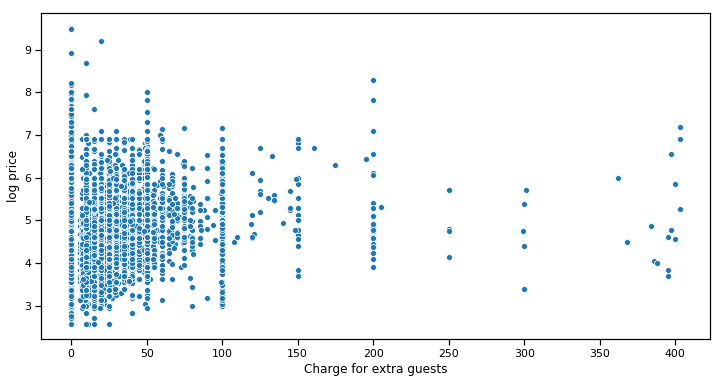

In [178]:
sns.scatterplot(data=df,x='extra_people',y='log_price')
plt.xlabel('Charge for extra guests')
plt.ylabel('log price');

There are two meanings for no excharge: 1. the number of guests included is the same as its maximum capacity; or 2. there is no extra charge for addition guests.  

The scatter plot shows that there is no obvious correlation between log price and extra charge.

### 2.5.4.a What is the distribution of minimum nights of stay?

In [362]:
df.minimum_nights.describe()

count    20765.000000
mean         6.292367
std         29.359581
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       1125.000000
Name: minimum_nights, dtype: float64

In [361]:
print(f'Number of unique minimum nights is {len(df.minimum_nights.unique())}')

Number of unique minimum nights is 95


In [374]:
print(f'Percentage of minimum nights 7 days or less is {(df.minimum_nights <=7).sum()/df.shape[0]*100:.3}')

Percentage of minimum nights 7 days or less is 91.8


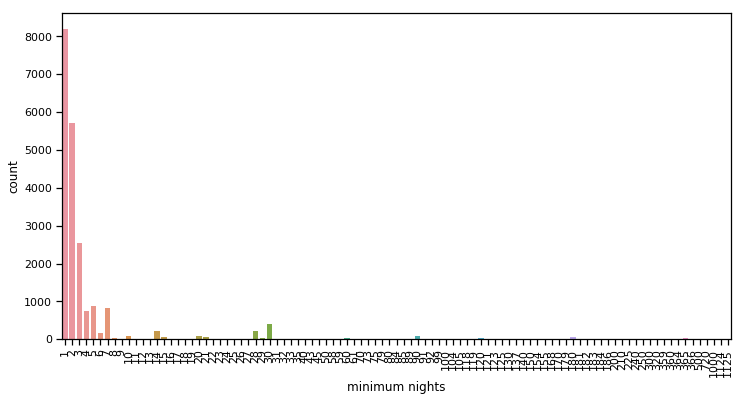

In [369]:
sns.countplot(data=df, x='minimum_nights')
plt.xticks(rotation=90)
plt.xlabel('minimum nights')
plt.ylabel('count');

The minimum nights show considerable variation, with the minimum and maximum values of 1 and 1125, respectively. Yet, a majority (92%) of the listings have minimum nights of 7 days or less.  

The minimum nights of stay represents two business models. The first model targets short-term customers, while the other model targets those looking for longer terms.

### 2.5.4.b Is the minimum nights of stay related to price? 

''

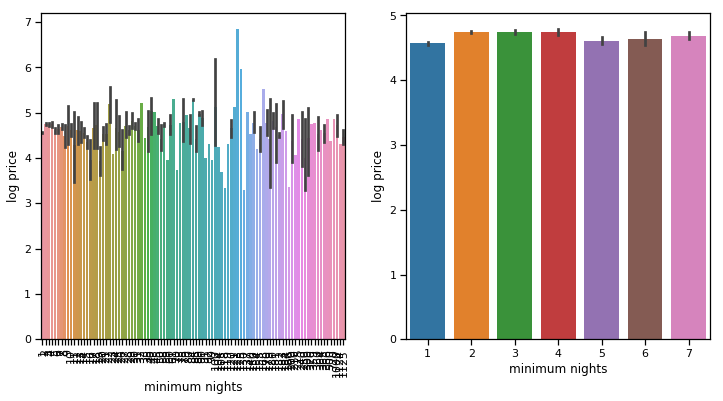

In [181]:
plt.subplot(1,2,1)
sns.barplot(data=df, x='minimum_nights',y='log_price')
plt.xlabel('minimum nights')
plt.ylabel('log price')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.barplot(data=df[df.minimum_nights <=7], x='minimum_nights',y='log_price')
plt.xlabel('minimum nights')
plt.ylabel('log price')
;

The left bar plot shows the log price across the entire range of minimum nights of stay. There is no obvious trend; yet, note that data is scarce for higher minimum nights.  

The right bar plot shows there is a difference in median log price for minimum nights between 1 and 7. However the trend is non-linear.

### 2.5.5.a What is the distribution of cancellation policy?

Cancellation policy can be incorporated into the pricing strategy. A more stringent policy provides more protection to the host, while a more lax policy can be more attractive to the guest.

In [1]:
count_pct('cancellation_policy')

NameError: name 'count_pct' is not defined

There are 5 types of policies, with the policy of notification of 14 days in advance with grace period the most common.

### 2.5.5.b Is price related to cancellation policy?

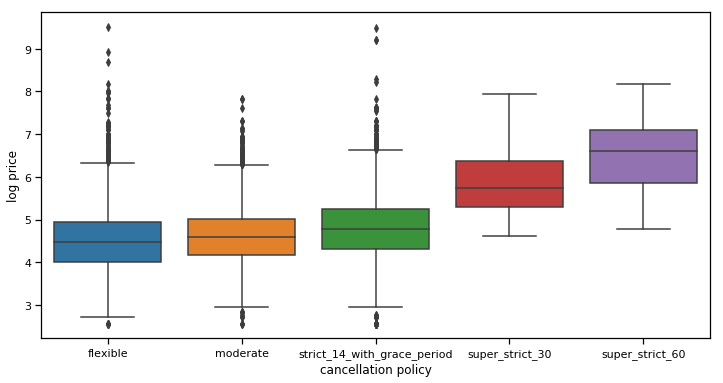

In [187]:
order = ['flexible','moderate','strict_14_with_grace_period','super_strict_30','super_strict_60']
sns.boxplot(data=df, x='cancellation_policy',y='log_price',order=order)
plt.xlabel('cancellation policy')
plt.ylabel('log price');

The median log price is the highest for the policy that requires 60 days of notice, and lowest for the flexible policy. Nonetheless, the numbers of data points are considerably lower for the two strictest policies.

## 2.6 Review score ratings

### 2.6.1.a What is the distribution of review score ratings?

In [64]:
df.review_scores_rating.describe()

count    20765.000000
mean        94.964604
std          7.226344
min         20.000000
25%         94.000000
50%         97.000000
75%         99.000000
max        100.000000
Name: review_scores_rating, dtype: float64

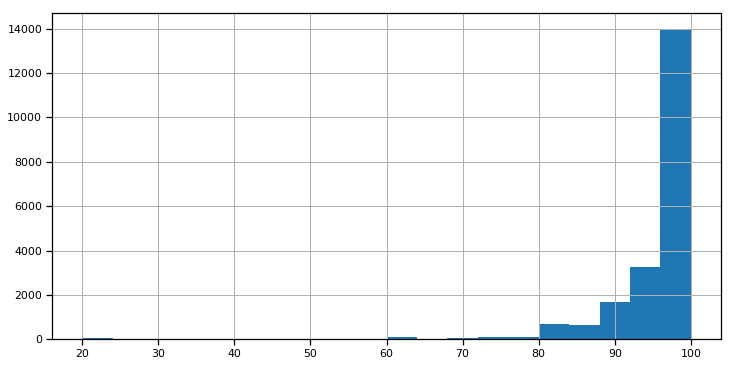

In [66]:
df.review_scores_rating.hist(bins=20);

The highest and lowest review score ratings are 100 and 20, respectively.

The review score ratings are top heavy, with 75% of data 94 or higher.

### 2.6.1.b. Is there a difference in review score between superhost and non-superhost?

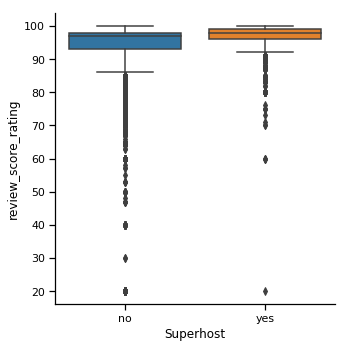

In [68]:
g=sns.catplot(data=df, y='review_scores_rating', x='host_is_superhost', kind='box')
g.set(xlabel='Superhost',ylabel='review_score_rating')
plt.xticks([0,1],['no',"yes"]);

### 2.6.1.c Is price related to review score ratings?

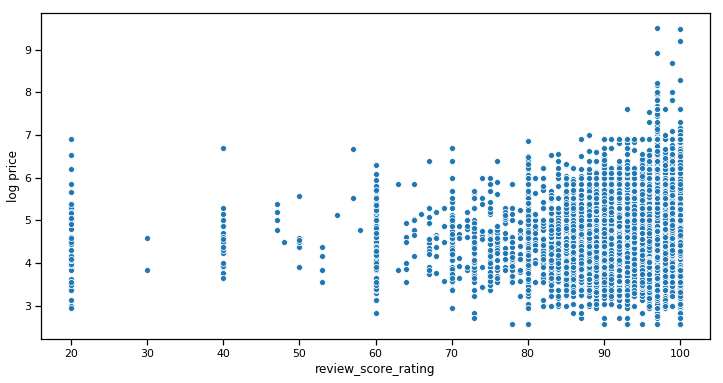

In [69]:
sns.scatterplot(data=df,y='log_price',x='review_scores_rating')
plt.xlabel('review_score_rating')
plt.ylabel('log price');

There seems to be no obvious relationship between price and review score rating.

# 3. Conclusions

Through data visualization, we review some interesting facts about this dataset.
1. The price is highly right skewed due to extreme outliers. Log transformation is applied to reduce the extremity for better visualization.
2. The number of listings and prices are different across the various regions. Toronto has the highest number of listings, followed by York. The median price is highest in Downtown Toronto, followed by Central Toronto.
3. The most abundant property types are apartments, condominiums and houses. Price is dependent on property type. Condominium has the highest price, followed by houses and apartments.  
4. Price is also dependent on room type. The room type of entire Unit has the highest price, followed by private room. Shared room has the lowest price.
5. Booking policies such minimum nights of stay, number of guests included, and cancellation policy have an effect on price. 
6. The median price for listings provided by superhosts are slightly higher than that of non-superhosts.